In [ ]:
from langchain.agents import create_agent
from langchain_core.tools import tool, render_text_description_and_args
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
import os
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, render_text_description_and_args
from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

from IPython.display import Image, display

from langchain_community.document_loaders import PyMuPDFLoader, DirectoryLoader
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
import re
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

from typing import TypedDict
from transformers import AutoTokenizer
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.retrievers import BM25Retriever

# from langchain.retrievers import EnsembleRetriever
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [3]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.agents.structured_output import ToolStrategy

In [4]:
from langchain_core.runnables.graph import MermaidDrawMethod

### main

In [ ]:
load_dotenv()

In [ ]:
'OPENAI_API_KEY' in os.environ, 'OPENROUTER_API_KEY' in os.environ

In [7]:
llm = ChatOpenAI(
    model='gpt-4o-mini-2024-07-18',
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv('OPENROUTER_API_KEY')
)

In [8]:
def display_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
class GroundingState(TypedDict):
  documents: list[Document]
  chunks: list[Document]
  vector_store: any
  retriever: any

In [10]:
def load_and_clean_pdfs(state: GroundingState):
    dir_path = 'C:/Users/Виктория/OneDrive/LPNU/7_семестр_(4)/Deep Learning/Labs_DL/DL_lab7_Bulatova'
    dir_loader = DirectoryLoader(path=dir_path,
                                 glob='./*.pdf',
                                 loader_cls=PyMuPDF4LLMLoader
                                 )

    orig_docs = dir_loader.load()
    print(f'docs found: {len(orig_docs)}')

    cleaned_docs = []
    for doc in orig_docs:
        text = doc.page_content
        text = re.sub(r'(\w+)-\n(\w+)', r'\1\2', text)
        paragraphs = re.split(r'\n\s*\n', text)
        cleaned_paragraphs = []

        for p in paragraphs:
            clean_p = re.sub(r'\s+', ' ', p).strip()
            if clean_p:
                cleaned_paragraphs.append(clean_p)

        text = '\n\n'.join(cleaned_paragraphs)
        doc.page_content = text
        cleaned_docs.append(doc)
    return {'documents': cleaned_docs}

In [11]:
def chunk_docs(state: GroundingState):
  raw_docs = state['documents']
  tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base')
  separators = ['\n\n', '\n', '.', ' ', '']

  rec_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
      tokenizer,chunk_size=250,
      chunk_overlap=25,
      separators=separators,
      keep_separator='end'
      )

  chunks = rec_splitter.split_documents(raw_docs)
  return {'chunks': chunks}

In [12]:
def index_chunks_and_build_retriever(state:GroundingState):
  chunks = state['chunks']
  embedding = HuggingFaceEmbeddings(model_name='intfloat/multilingual-e5-base')
  vector_store = InMemoryVectorStore.from_documents(chunks, embedding)

  mmr_retriever = vector_store.as_retriever(search_kwargs={"search_type": "mmr", 'k': 5, 'fetch_k': 30, 'lambda_mult': 0.5})
  return {'vector_store': vector_store, 'retriever': mmr_retriever}

In [13]:
ground_graph = StateGraph(GroundingState)
ground_graph.add_node(load_and_clean_pdfs)
ground_graph.add_node(chunk_docs)
ground_graph.add_node(index_chunks_and_build_retriever)

ground_graph.add_edge(START, 'load_and_clean_pdfs')
ground_graph.add_edge('load_and_clean_pdfs', 'chunk_docs')
ground_graph.add_edge('chunk_docs', 'index_chunks_and_build_retriever')
ground_graph.add_edge('index_chunks_and_build_retriever', END)

ground_graph_compiled = ground_graph.compile()

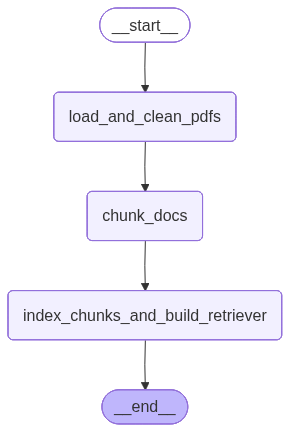

In [14]:
display_graph(ground_graph_compiled)

In [ ]:
graph_state = ground_graph_compiled.invoke({
    'documents': None,
    'chunks': None,
    'vector_store': None,
    'retriever': None
})

In [16]:
retr_graph_state = graph_state['retriever']

In [17]:
@tool
def retriever_tool(question:str):
  """Здійснює пошук релевантних до запиту документів про Львівську політехніку й зокрема кадрове забезпечення"""
  docs = retr_graph_state.invoke(question)
  if not docs:
    return 'no docs found'
  return '\n\n'.join([f'source {i+1}: {doc.page_content}' for i, doc in enumerate(docs)])

In [18]:
api_wrapper = WikipediaAPIWrapper(
  lang='uk',
  top_k_results=3,
  doc_content_chars_max=1000
)

wiki = WikipediaQueryRun(api_wrapper=api_wrapper)

In [19]:
@tool
def math_wiki_tool(question:str):
  """Здійснює пошук коротких визначень математичних об’єктів чи формул тощо"""
  print(f'searching: {question}')
  return wiki.run(question)

In [20]:
tools = [retriever_tool, math_wiki_tool]

In [21]:
sys_prompt = SystemMessage(
    "Ти — корисний асистент. Твоя спеціалізація — це дві теми: "
    "1. Національний університет 'Львівська політехніка' (НУЛП). "
    "2. Математичні визначення та формули тощо (МАТЕМАТИКА). "
    "Якщо питання стосується цих тем — надай вичерпну відповідь. "
    "Якщо питання НЕ стосується цих тем — ввічливо відмов відповідати (поза темою)."
    )

In [22]:
class ResponseFormat(BaseModel):
    response: str = Field(description="Текстова відповідь користувачу.")
    category: Literal['НУЛП', 'МАТЕМАТИКА', 'поза темою'] = Field(description="Категорія теми, до якої належало питання.")
    sources_used: list[str] = Field(description="Список назв інструментів, які реально використовувалися (наприклад, 'retriever_tool'). Якщо нічого - порожній список.")

In [23]:
memory_saver = InMemorySaver()

In [24]:
pathetic_agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=sys_prompt,
    response_format = ToolStrategy(ResponseFormat),
    checkpointer=memory_saver
)

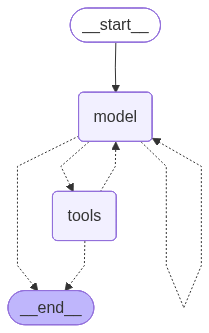

In [25]:
display_graph(pathetic_agent)

In [26]:
ques_1 = 'Який робочий час завідувача кафедри?'
ques_2 = 'Яке геометричне значення визначеного інтегралу?'
ques_3 = 'Чому Тернопіль краще за Хмельницький?'

In [27]:
questions = [ques_1, ques_2, ques_3]

In [28]:
configuration = {"configurable": {"thread_id": 'first_try'}}

In [29]:
for ques in questions:
    for event in pathetic_agent.stream({"messages": [("human", ques)]}, config=configuration, stream_mode="values"): 
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Який робочий час завідувача кафедри?
================================== Ai Message ==================================
Tool Calls:
  retriever_tool (call_YSwfpymAkLg4GtA8gxEyDwV6)
 Call ID: call_YSwfpymAkLg4GtA8gxEyDwV6
  Args:
    question: робочий час завідувача кафедри НУЛП
================================= Tool Message =================================
Name: retriever_tool

source 1: Додаток до контракту №___

**Ключові показники результативності завідувача кафедри**

**____________________________________________**

source 2: 101|Частка<br>середнього<br>навчального<br>навантаження НПП кафедри в<br>середньому<br>навчальному<br>навантаженні<br>НПП<br>по<br>Університету||Вхідні дані для розрахунків<br>вносить відділ кадрового<br>забезпечення|**1**<br>**(1)**<br>_Середнє планове_|**1 **|||||| |**3.**|**Наукова діяльність**|**Наукова діяльність**|**Наукова діяльність**|**Наукова діяльність**|**Наукова діял